# Constructing the toy model with SRD correlation

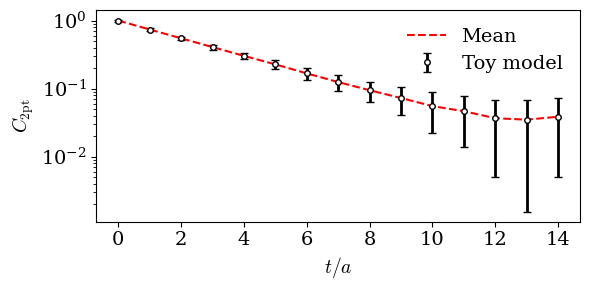

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_configs = 420       # Number of gauge configurations
n_timeslices = 27     # Number of time slices
n_plot_slices = 15    # Time slice truncation before the signal starts to deteriorate
np.random.seed(42)

# Toy data- Lattice QCD 2pt function falls exponentially with time
def pion_2pt_model(t, mass=0.3, amp=1.0):
    return amp * (np.exp(-mass * t) + np.exp(-mass * (n_timeslices - t)))

# Baseline signal
t_values = np.arange(n_timeslices)
signal = pion_2pt_model(t_values)

# Generate short-range correlated noise using AR(1) process
rho = 0.4  # Correlation coefficient
noise = np.random.normal(0, 0.03, (n_configs, n_timeslices))
for i in range(1, n_configs):
    noise[i] += rho * noise[i - 1]  # AR(1) correlation

# Total toy data
C_data = signal + noise

# Compute statistics for the first 15 time slices (up to slice 14)
t_plot_values = t_values[:n_plot_slices]
C_data_plot = C_data[:, :n_plot_slices]

mean_2pt = np.mean(C_data_plot, axis=0)
std_dev = np.std(C_data_plot, axis=0)

plt.rcParams.update({
    "font.family": "serif",  # Use serif fonts
    "mathtext.fontset": "cm",  # Use Computer Modern for math text
    "axes.labelsize": 14,  # Axis label font size
    "axes.titlesize": 14,  # Title font size
    "xtick.labelsize": 12,  # X-axis tick font size
    "ytick.labelsize": 12,  # Y-axis tick font size
    "legend.fontsize": 14,  # Legend font size
})

plt.figure(figsize=(6, 3))
plt.errorbar(
    t_plot_values, mean_2pt, yerr=std_dev,
    fmt='o',
    ecolor='black',
    elinewidth=2,
    capsize=3,
    markerfacecolor='white',
    markeredgecolor='black',
    markeredgewidth=1,
    markersize=4,
    label='Toy model'
)
plt.plot(t_plot_values,mean_2pt, 'r--', label='Mean')
plt.yscale('log')
plt.xlabel(r"$t/a$", fontsize=14)
plt.ylabel(r"$C_{\mathrm{2pt}}$", fontsize=14)
plt.legend(frameon=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.tight_layout()
plt.savefig("plots/toy_model.pdf", format = "pdf",dpi=600, bbox_inches='tight')
plt.show()

## Checking the distribution

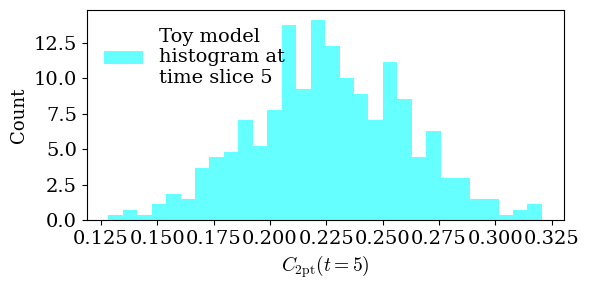

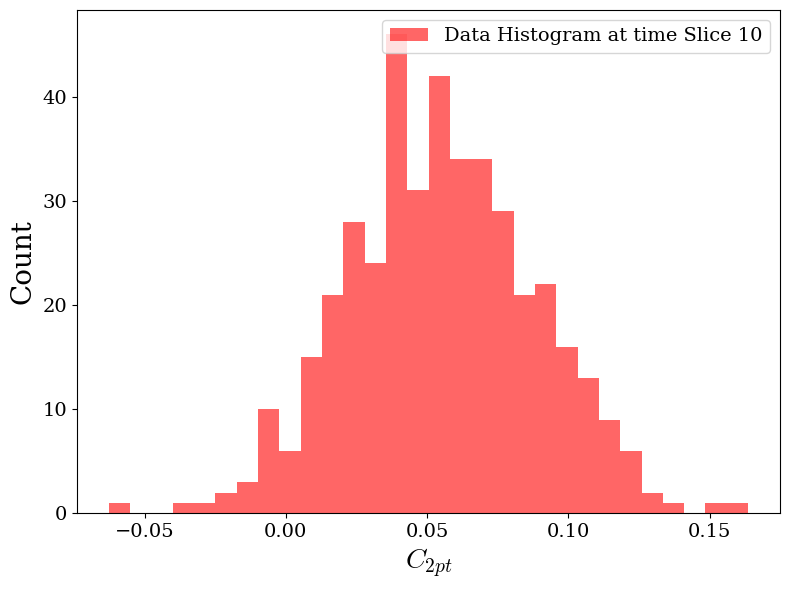

In [22]:
""" CHECKING THE DISTRIBUTION OF THE TOY MODEL DATA """

time_slice_index_1 = 5
time_slice_index_2 = 10
data_at_slice_1 = C_data_plot[:, time_slice_index_1]
data_at_slice_2 = C_data_plot[:, time_slice_index_2]

plt.rc('font', family='serif')
plt.figure(figsize=(6, 3))
plt.hist(data_at_slice_1, bins=30, alpha=0.6, color='cyan', density=True, label=f'Toy model\nhistogram at \ntime slice {time_slice_index_1}')

#plt.title(f"Histogram of Measurements for the toy model at Time Slice {time_slice_index_1}")
plt.xlabel(r"$C_{\mathrm{2pt}}(t=5)$", fontsize=14)
plt.ylabel("Count", fontsize=13)
plt.legend(frameon=False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("plots/toy_model_distribution.pdf", format = "pdf",dpi=600, bbox_inches='tight' )

plt.show()

plt.rc('font', family='serif')
plt.figure(figsize=(8, 6))
plt.hist(data_at_slice_2, bins=30, alpha=0.6, color='red', label=f'Data Histogram at time Slice {time_slice_index_2}')
#plt.plot(x, pdf, 'r-', lw=2, label=f"Normal Fit\nMean={mean:.5f}, Std={std:.5f}")
#plt.title(f"Histogram of Measurements for the toy model at time Slice {time_slice_index_2}")
plt.xlabel("$C_{2pt}$", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.legend()
#plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig("plots/toy_model_distribution t=15.pdf", format = "pdf",dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [23]:
""" VERIFYING NORMAL DISTRIBUTION """

within_1_sigma = np.sum((C_data_plot[:,10] >= mean_2pt[10] - std_dev[10]) & (C_data_plot[:,10] <= mean_2pt[10] + std_dev[10])) / len(C_data_plot[:,10]) * 100
within_2_sigma = np.sum((C_data_plot[:,10] >= mean_2pt[10] - 2*std_dev[10]) & (C_data_plot[:,10] <= mean_2pt[10] + 2*std_dev[10])) / len(C_data_plot[:,10]) * 100
within_3_sigma = np.sum((C_data_plot[:,10] >= mean_2pt[10] - 3*std_dev[10]) & (C_data_plot[:,10] <= mean_2pt[10] + 3*std_dev[10])) / len(C_data_plot[:,10]) * 100

# Print results
print("VERIFYING NORMAL DISTRIBUTION FOR THE TOY MODEL:")
print(f"Data within 1σ: {within_1_sigma:.2f}% (Expected: ~68%)")
print(f"Data within 2σ: {within_2_sigma:.2f}% (Expected: ~95%)")
print(f"Data within 3σ: {within_3_sigma:.2f}% (Expected: ~99.7%)")

VERIFYING NORMAL DISTRIBUTION FOR THE TOY MODEL:
Data within 1σ: 67.14% (Expected: ~68%)
Data within 2σ: 96.43% (Expected: ~95%)
Data within 3σ: 99.52% (Expected: ~99.7%)


## Functions

In [24]:
""" RESAMPLING TECHNIQUES """
def jackknife(data):
    n_configs, n_times = data.shape
    means = np.zeros((n_configs, n_times))
    for i in range(n_configs):
        means[i, :] = np.mean(np.delete(data, i, axis=0), axis=0)
    mean = np.mean(means, axis=0)
    error = np.sqrt((n_configs - 1) * np.mean((means - mean) ** 2, axis=0))
    return mean, error, means

def bootstrap(data, num_resamples):

    n_configs, n_times = data.shape
    bootstrap_data = np.zeros((num_resamples, n_times))  # Initialize 2D array

    for t in range(n_times):  # Iterate over time slices
        for i in range(num_resamples):  # For each bootstrap resample
            bootstrap_data[i, t] = np.random.choice(data[:, t], replace=True)
    bootstrap_means = np.mean(bootstrap_data, axis=0)
    bootstrap_error = np.std(bootstrap_data, axis=0)

    return bootstrap_means, bootstrap_error, bootstrap_data


def block_resample(data, block_size):
    n_blocks = data.shape[0] // block_size 
    reshaped = data[:n_blocks * block_size].reshape(n_blocks, block_size, data.shape[1])
    return np.mean(reshaped, axis=1)  # shape: (n_blocks, n_timeslices)

## Jackknife Resampling

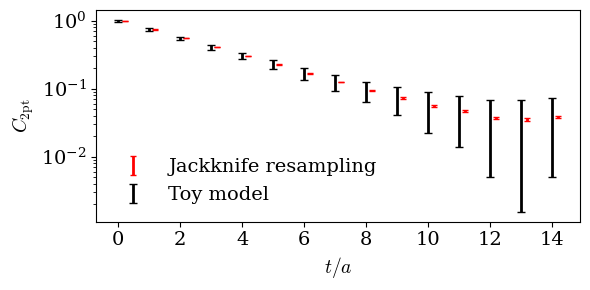

In [25]:
""" JACKKNIFE RESAMPLING """
jackknife_mean, jackknife_error, jackknife_data = jackknife(C_data_plot)

plt.figure(figsize=(6, 3))

# Plot error bars and uncertainty band
plt.errorbar(t_plot_values+0.2, jackknife_mean, yerr=jackknife_error, fmt='none', elinewidth=2, ecolor='red', capsize=2, label='Jackknife resampling')
plt.errorbar(t_plot_values, mean_2pt, yerr=std_dev, fmt='none', ecolor='black', elinewidth=2, capsize=3, label='Toy model')
plt.yscale('log')
plt.xlabel(r"$t/a$", fontsize=14)
plt.ylabel(r"$C_{\mathrm{2pt}}$", fontsize=14)
plt.legend(frameon=False)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig("plots/jackknife_uncertainty.pdf", format="pdf", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Bootstrap Resampling

In [26]:
""" BOOTSTRAP RESAMPLING """

num_resamples_1 = 100
num_resamples_2 = 1000
num_resamples_3 = 10000
num_resamples_4 = 100000

np.random.seed(42)

bootstrap_means_1, bootstrap_error_1, bootstrap_data_1 = bootstrap(C_data_plot, num_resamples_1)
bootstrap_means_2, bootstrap_error_2, bootstrap_data_2 = bootstrap(C_data_plot, num_resamples_2)
bootstrap_means_3, bootstrap_error_3, bootstrap_data_3 = bootstrap(C_data_plot, num_resamples_3)
bootstrap_means_4, bootstrap_error_4, bootstrap_data_4 = bootstrap(C_data_plot, num_resamples_4)

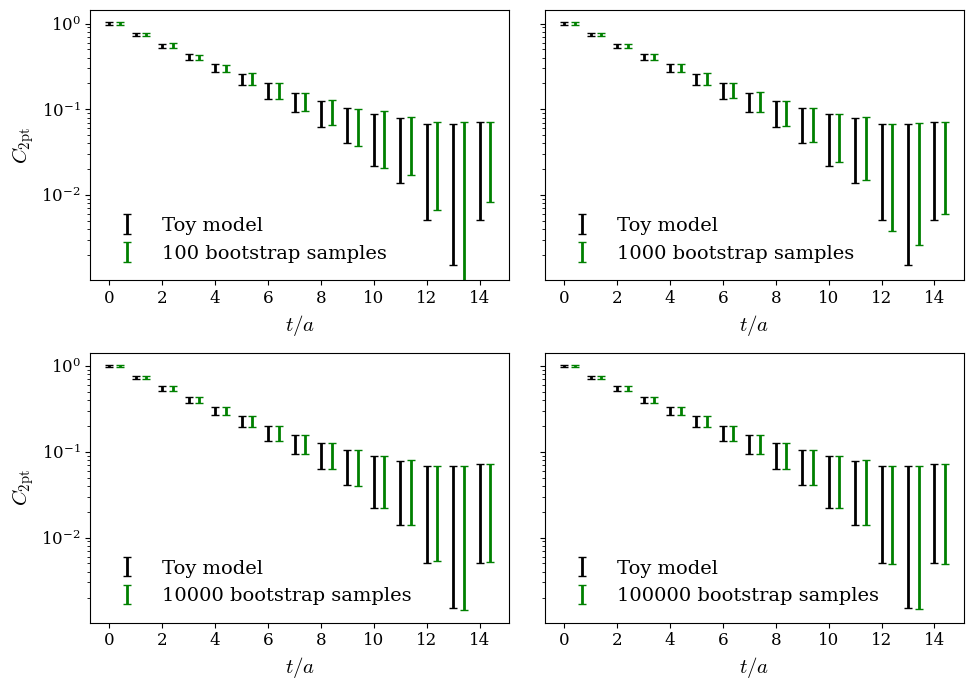

In [27]:
"""PLOTTING THE BOOTSTRAP RESAMPLING"""

bootstrap_samples = [num_resamples_1, num_resamples_2, num_resamples_3, num_resamples_4]
bootstrap_average = [bootstrap_means_1, bootstrap_means_2, bootstrap_means_3, bootstrap_means_4]
bootstrap_unc =[bootstrap_error_1, bootstrap_error_2, bootstrap_error_3, bootstrap_error_4]


fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharey=True)

axes = axes.flatten()

for i, ax in enumerate(axes):
    samples = bootstrap_samples[i]

    ax.errorbar(
        t_plot_values, mean_2pt, yerr=std_dev, fmt='none',
    ecolor='black',
    elinewidth=2,
    capsize=3,
    markerfacecolor='white',
    markeredgecolor='black',
    markeredgewidth=1,
    markersize=4,
        label='Toy model'
    )

    ax.errorbar(
        t_plot_values + 0.4, bootstrap_average[i], yerr=bootstrap_unc[i],
        ecolor='green', fmt='none',
    elinewidth=2,
    capsize=3,
    markerfacecolor='white',
    markeredgecolor='green',
    markeredgewidth=1,
    markersize=4,
        label=f"{bootstrap_samples[i]} bootstrap samples"
    )

    ax.set_yscale('log')
    ax.set_xlabel(r"$t/a$", fontsize=15)
    if i % 2 == 0:
        ax.set_ylabel(r"$C_{\mathrm{2pt}}$", fontsize=15)
    ax.legend(frameon=False)

plt.tight_layout()
plt.savefig(
    "plots/bootstrap_resampling.pdf",
    format="pdf", dpi=600, bbox_inches='tight')

plt.show()

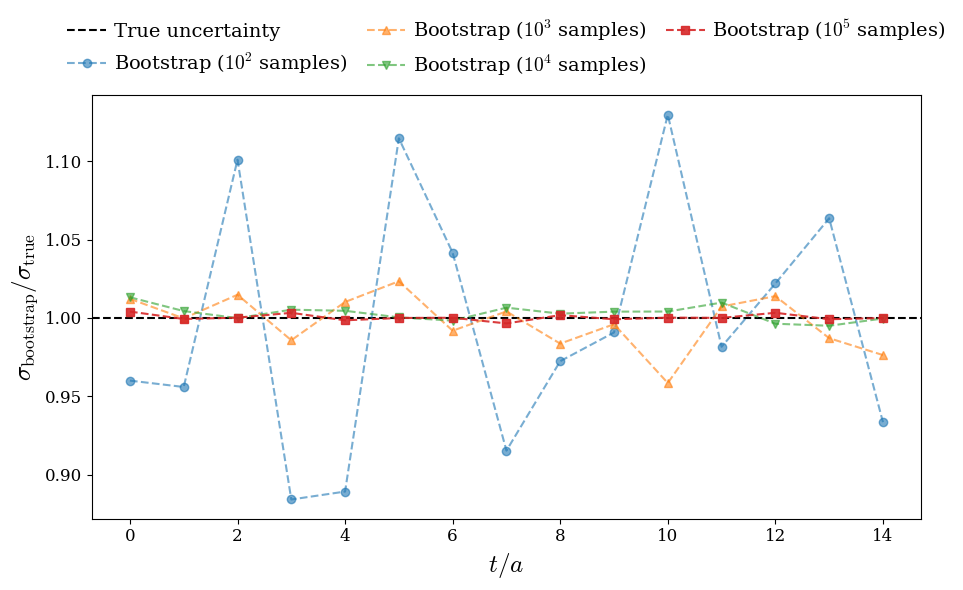

In [28]:
# Compute ratios
ratio_1 = bootstrap_error_1 / std_dev
ratio_2 = bootstrap_error_2 / std_dev
ratio_3 = bootstrap_error_3 / std_dev
ratio_4 = bootstrap_error_4 / std_dev


plt.figure(figsize=(10, 6))
plt.axhline(1.0, color='k', linestyle='--', label='True uncertainty')
plt.plot(t_plot_values, ratio_1, 'o--', label='Bootstrap ($10^2$ samples)', alpha=0.6)
plt.plot(t_plot_values, ratio_2, '^--', label='Bootstrap ($10^3$ samples)', alpha=0.6)
plt.plot(t_plot_values, ratio_3, 'v--', label='Bootstrap ($10^4$ samples)', alpha=0.6)
plt.plot(t_plot_values, ratio_4, 's--', label='Bootstrap ($10^5$ samples)', alpha=0.9)

plt.xlabel('$t/a$', fontsize=18)
plt.ylabel(r'$\sigma_\mathrm{bootstrap}/\sigma_\mathrm{true}$', fontsize=18)
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    frameon=False,
    handletextpad=0.4,
    columnspacing=1
)
plt.tight_layout()
plt.savefig('plots/bootstrap_ratio.pdf', format="pdf", dpi=600, bbox_inches='tight')
plt.show()


## Blocking Resampling

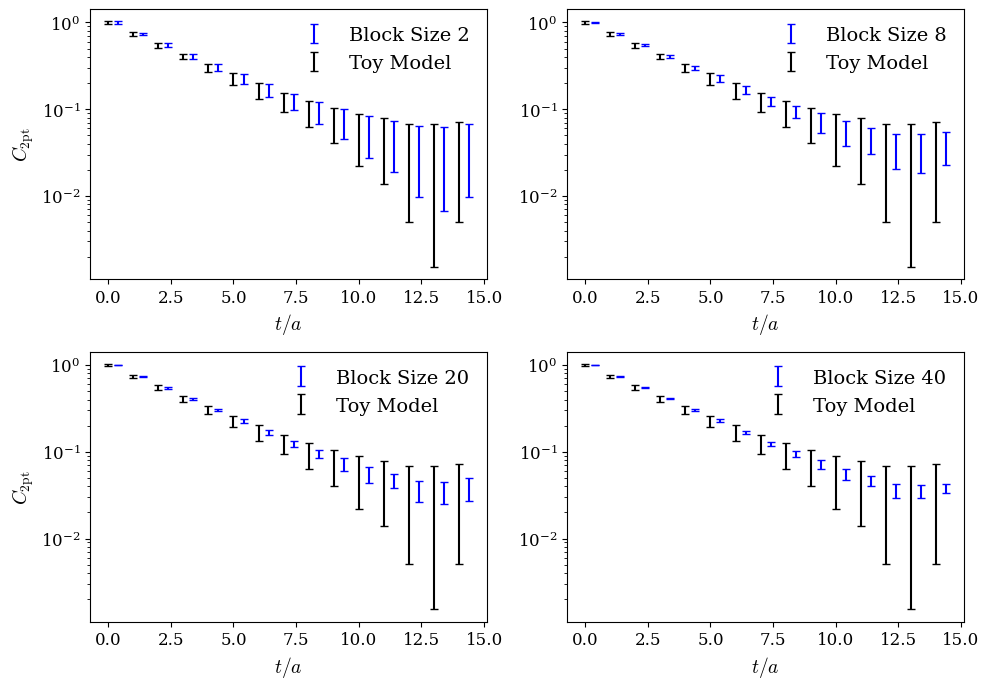

In [29]:
block_sizes = [2, 8, 20, 40]
block_resampled = []
block_errors = []

for block_size in block_sizes:
    resampled_data = block_resample(C_data_plot, block_size)
    block_mean = np.mean(resampled_data, axis=0)
    block_error = np.std(resampled_data, axis=0, ddof=1)
    block_resampled.append((block_size, block_mean))
    block_errors.append((block_size, block_error))


fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i, (block_size, mean_b) in enumerate(block_resampled):
    ax = axes[i]
    _, err_b = block_errors[i]

    ax.errorbar(
        t_plot_values + 0.4, mean_b, yerr=err_b,
        fmt='none',
        ecolor='blue', capsize=3, label=f'Block Size {block_size}'
    )
    ax.errorbar(
        t_plot_values, mean_2pt, yerr=std_dev,
        fmt='none',
        ecolor='black', capsize=3, label='Toy Model'
    )

    ax.set_yscale('log')
    ax.set_xlabel(r"$t/a$", fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel(r"$C_{\mathrm{2pt}}$", fontsize=14)
    ax.legend(frameon=False)

plt.tight_layout()
plt.savefig(
    "plots/blocking_resampling.pdf",
    format="pdf", dpi=600, bbox_inches='tight')
plt.show()

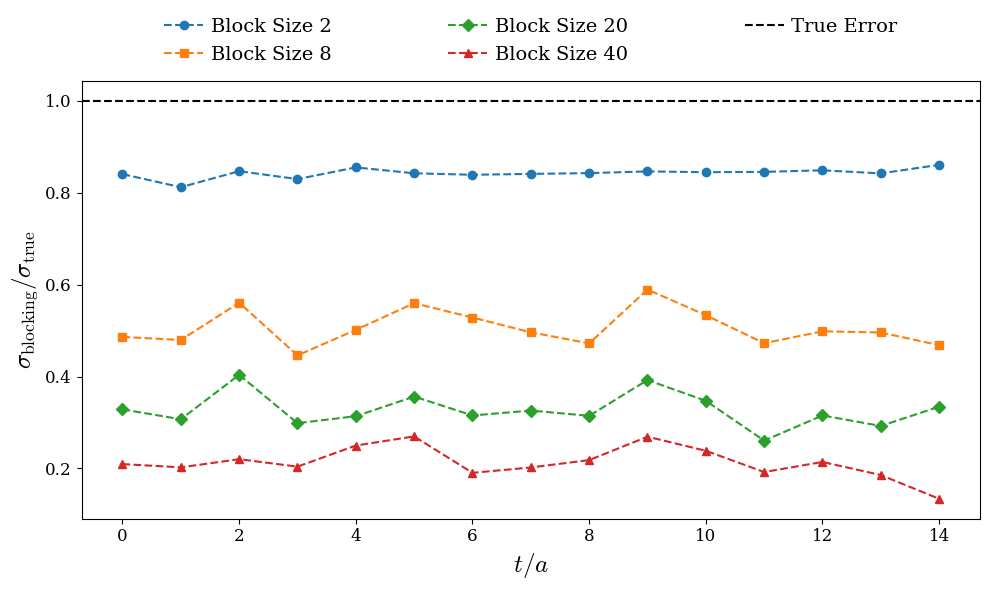

In [9]:
block_sizes = [2, 8, 20, 40]
error_ratios = []

for block_size in block_sizes:
    resampled_data = block_resample(C_data_plot, block_size)
    block_error = np.std(resampled_data, axis=0, ddof=1)
    error_ratio = block_error / std_dev
    error_ratios.append((block_size, error_ratio))


plt.figure(figsize=(10, 6))
markers = ['o', 's', 'D', '^']

for (block_size, ratio), marker in zip(error_ratios, markers):
    plt.plot(t_plot_values, ratio, marker=marker,linestyle='--', label=f'Block Size {block_size}')

plt.axhline(1.0, color='k', linestyle='--', label='True Error')
plt.xlabel(r"$t/a$", fontsize=18)
plt.ylabel(r'$\sigma_\mathrm{blocking}/\sigma_\mathrm{true}$', fontsize=18)
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    frameon=False,
    handletextpad=0.4,
    columnspacing=6
)
plt.tight_layout()
plt.savefig(
    "/media/shovon-rahman/Documents/Academics/Research/MS Thesis/After rejection/April 2025/blocking_ratio.pdf",
    format="pdf", dpi=600, bbox_inches='tight')
plt.show()

# Additional investigation

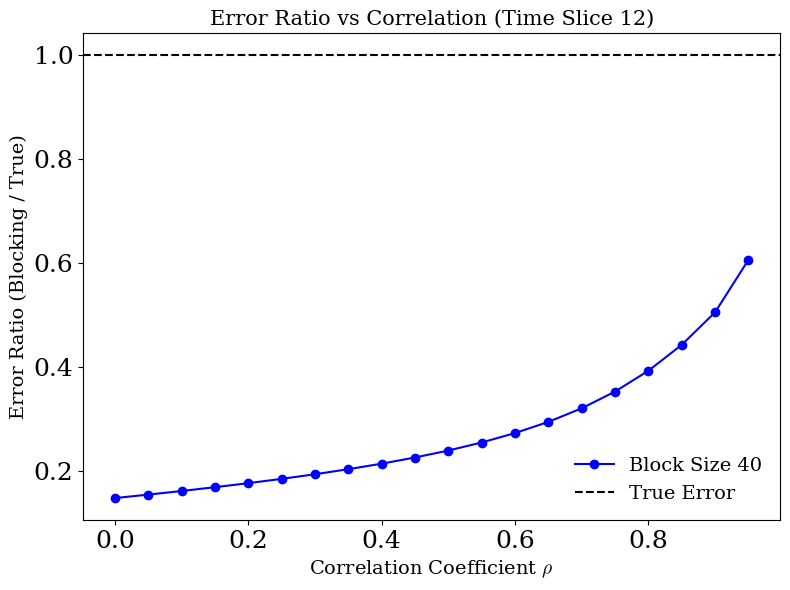

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the sweep
n_configs = 420
n_timeslices = 27
n_plot_slices = 15
t_values = np.arange(n_timeslices)
t_plot_values = t_values[:n_plot_slices]

# Toy model function
def pion_2pt_model(t, mass=0.3, amp=1.0):
    return amp * (np.exp(-mass * t) + np.exp(-mass * (n_timeslices - t)))

signal = pion_2pt_model(t_values)

# Block resampling
def block_resample(data, block_size):
    n_blocks = data.shape[0] // block_size 
    reshaped = data[:n_blocks * block_size].reshape(n_blocks, block_size, data.shape[1])
    return np.mean(reshaped, axis=1)

# Sweep over different correlation strengths
rhos = np.linspace(0.0, 0.95, 20)
block_size = 40
slice_index = 12  # Arbitrary time slice for comparison
error_ratios = []

for rho in rhos:
    np.random.seed(42)
    noise = np.random.normal(0, 0.03, (n_configs, n_timeslices))
    for i in range(1, n_configs):
        noise[i] += rho * noise[i - 1]
    C_data = signal + noise
    C_data_plot = C_data[:, :n_plot_slices]

    std_true = np.std(C_data_plot[:, slice_index], ddof=1)
    resampled_data = block_resample(C_data_plot, block_size)
    block_error = np.std(resampled_data[:, slice_index], ddof=1)
    ratio = block_error / std_true
    error_ratios.append(ratio)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(rhos, error_ratios, marker='o', linestyle='-', color='blue', label=f'Block Size {block_size}')
plt.axhline(1.0, linestyle='--', color='k', label='True Error')
plt.xlabel(r"Correlation Coefficient $\rho$", fontsize=14)
plt.ylabel("Error Ratio (Blocking / True)", fontsize=14)
plt.title(f"Error Ratio vs Correlation (Time Slice {slice_index})", fontsize=15)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


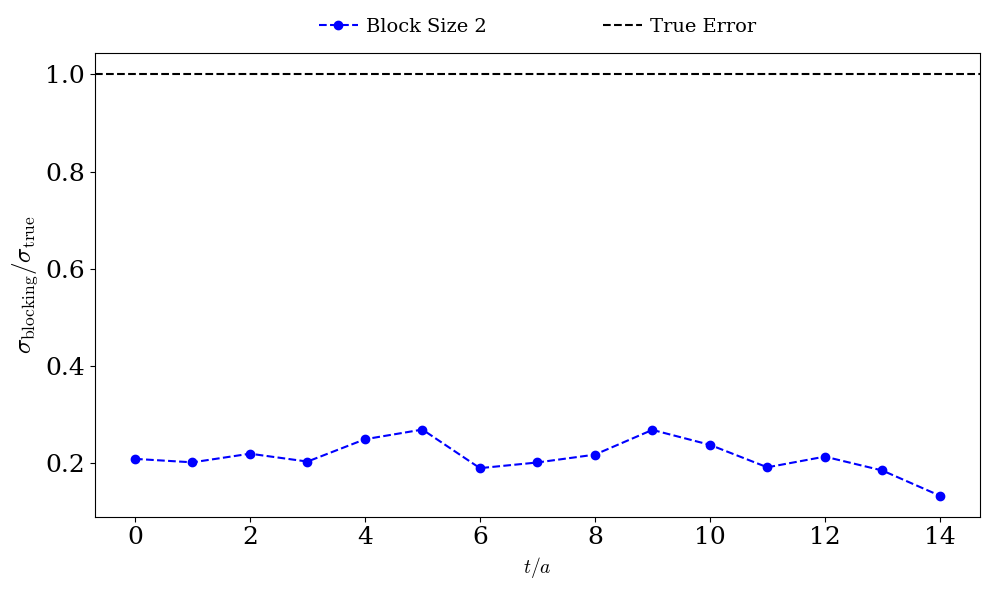

In [14]:
block_size = 40  # Only this block size
resampled_data = block_resample(C_data_plot, block_size)
block_error = np.std(resampled_data, axis=0, ddof=1)
error_ratio = block_error / std_dev

plt.figure(figsize=(10, 6))
plt.plot(t_plot_values, error_ratio, marker='o', linestyle='--', label='Block Size 2', color='blue')

plt.axhline(1.0, color='k', linestyle='--', label='True Error')

plt.xlabel(r"$t/a$", fontsize=14)
plt.ylabel(r'$\sigma_\mathrm{blocking}/\sigma_\mathrm{true}$', fontsize=18)

plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=2,
    frameon=False,
    handletextpad=0.4,
    columnspacing=6
)

plt.tight_layout()
plt.show()


# Final comparison

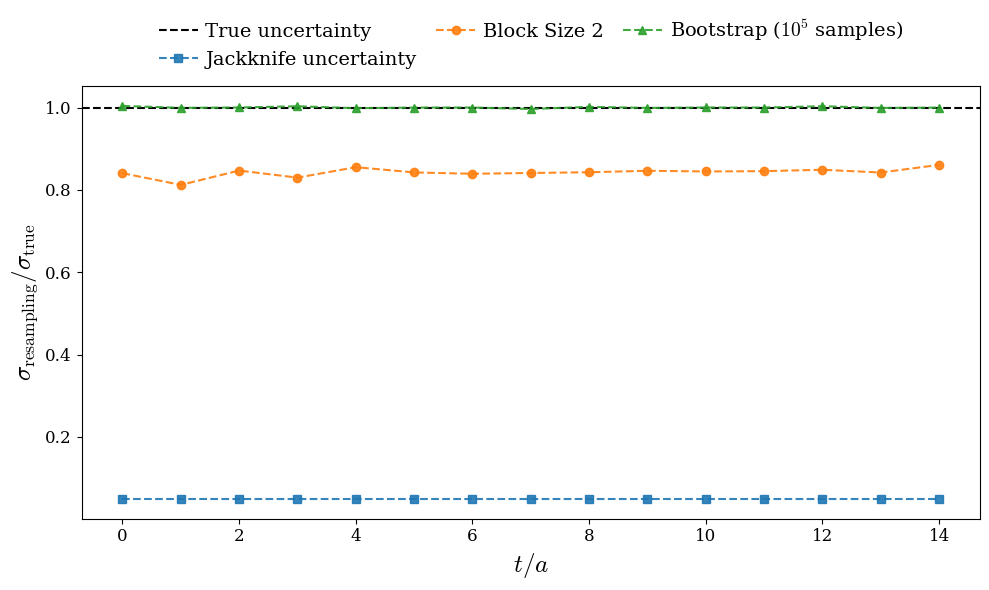

In [30]:
block_size = 2
resampled_data = block_resample(C_data_plot, block_size)
block_error = np.std(resampled_data, axis=0, ddof=1)
block_error_ratio = block_error / std_dev
jackknife_ratio = jackknife_error/std_dev

plt.figure(figsize=(10, 6))
plt.axhline(1.0, color='k', linestyle='--', label='True uncertainty')
plt.plot(t_plot_values, jackknife_ratio, 's--', label='Jackknife uncertainty', alpha=0.9)
plt.plot(t_plot_values, block_error_ratio, 'o--', label='Block Size 2', alpha=0.9)
plt.plot(t_plot_values, ratio_4, '^--', label='Bootstrap ($10^5$ samples)', alpha=0.9)

plt.xlabel('$t/a$', fontsize=18)
plt.ylabel(r'$\sigma_\mathrm{resampling}/\sigma_\mathrm{true}$', fontsize=18)
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    frameon=False,
    handletextpad=0.4,
    columnspacing=1
)
plt.tight_layout()
plt.savefig('plots/overall_ratio.pdf', format="pdf", dpi=600, bbox_inches='tight')
plt.show()
